## Introduction to NumPy and CNNs with ENCODE data

In this tutorial, we will download ENCODE data file, examine it's contents, and do a quick sanity check with NumPy and plotting library. This is normally the initial step before starting to preprocess the data. This notebook can be run on an instance of [AWS Deep Learning AMI](https://docs.aws.amazon.com/dlami/latest/devguide/what-is-dlami.html)

For this, we will pick experiment [ENCSR057BWO](https://www.encodeproject.org/experiments/ENCSR057BWO/). It's a ChIP-seq on H3K4me3 from GM12878 cell line. We know from PREDICTD paper that H3K4me3 was the most informative of all histone modifications. The file we are interested in is ENCFF565YYD, a bigWig of signal p-value. 


We will use [pyBigWig](https://github.com/deeptools/pyBigWig) python module that's specifically designed to work with bigWigs.

In [ ]:
import pyBigWig
from sklearn.model_selection import train_test_split
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from keras import backend as K
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = random.choice(['0','1'])

In [24]:
bw = pyBigWig.open('https://encode-public.s3.amazonaws.com/2016/11/14/fa0368ac-fae9-405e-9844-190631339d29/ENCFF565YYD.bigWig')
bw.chroms() # returns dictionary with chromosomes as key and number of entries as values

{'chrUn_KI270748v1': 93321,
 'chrUn_KI270337v1': 1121,
 'chrUn_KI270749v1': 158759,
 'chr1_KI270713v1_random': 40745,
 'chrUn_KI270418v1': 2145,
 'chr13': 114364328,
 'chr12': 133275309,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr17': 83257441,
 'chr16': 90338345,
 'chr15': 101991189,
 'chr14': 107043718,
 'chrUn_GL000218v1': 161147,
 'chr19': 58617616,
 'chr18': 80373285,
 'chrUn_KI270320v1': 4416,
 'chrUn_GL000219v1': 179198,
 'chrUn_KI270518v1': 2186,
 'chr3_GL000221v1_random': 155397,
 'chrUn_GL000213v1': 164239,
 'chrUn_KI270746v1': 66486,
 'chrUn_KI270516v1': 1300,
 'chr16_KI270728v1_random': 1872759,
 'chrUn_KI270521v1': 7642,
 'chrUn_GL000214v1': 137718,
 'chr9_KI270720v1_random': 39050,
 'chrUn_KI270593v1': 3041,
 'chrUn_KI270538v1': 91309,
 'chr22_KI270731v1_random': 150754,
 'chr1_KI270707v1_random': 32032,
 'chrUn_KI270322v1': 21476,
 'chrUn_KI270579v1': 31033,
 'chr1_KI270708v1_random': 127682,
 'chrUn_KI270378v1': 1048,
 'chrEBV': 171823,
 'chr15_KI270727v1_random': 4

It's useful because we then can use these values

In [2]:
bw.chroms()['chr1'] # number of entries

248956422

In [3]:
bw.values("chr1", 0, 3) # Three values from chromosome 1 at positions from 0 to 3

[0.05996999889612198, 0.05996999889612198, 0.05996999889612198]

248956422 values are too many for pyplot module to handle, so we bin the data by averaging values over 50pb. 

In [25]:
chrom1_number_of_bins = int(bw.chroms()['chr1'] / 50) # Calculate how many bins we should have
chrom1_binned_values = bw.stats('chr1', type='mean', nBins=chrom1_number_of_bins) # This takes some time 

Since it takes too long to load the data, we want to save the binned values so next time notebook restarts, we won't have to wait for it to be binned again. For this, we use HDF5 format and h5py python module. We first clean up the data from missing values. 

In [26]:
chrom1_numpy = np.array(chrom1_binned_values, dtype=float) # We are converting the values into float format
chrom1_clean_binned = np.nan_to_num(chrom1_numpy) # Converting missing values into 0

We now save the array into HDF5 formatted file. 

In [32]:
f = h5py.File('/data/chr1_binned_values', 'r+')
f.create_dataset('chrom1_50_binned', data=chrom1_clean_binned)
f.close()

We now get our data from the file that holds our processed data

In [33]:
f = h5py.File('/data/chr1_binned_values', 'r') # Opening file in read-only mode
chrom1_clean_50_binned = f.get('chrom1_50_binned')


get method of the module returns a class that wraps around the data, but we need numpy array. So:

In [34]:
chrom1_clean_50_binned = np.array(chrom1_clean_50_binned) # Converting to numpy array

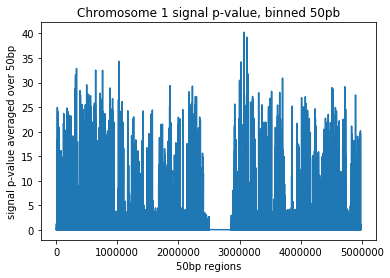

In [35]:
plt.plot(chrom1_clean_50_binned)
plt.title('Chromosome 1 signal p-value, binned 50pb')
plt.xlabel('50bp regions')
plt.ylabel('signal p-value averaged over 50bp')
plt.show()

This is great, but what can we do with it? The whole point of converting genomic data to numpy array was so that we could run some statistical analysis on it. Since neural networks are so in these days, let's try it out.

## Naive Introduction to Neural Networks with ENCODE data

Suppose we want to predict chromatin state from just the *H3K4me3* data. That's somewhat a difficult task, but we could start by asking whether *H3K4me3* can predict *H3K27ac*. In this case, *H3K4me3* data will be our input and *H3K27ac* our preduction output. Lucky for us, the same lab that produced the *H3K4me3* data also produced *H3K27ac* data from the same cell line. This will allow us to more accurately compare the prediction output of our model to the ground truth. Let's start beating *H3K27ac* data into a shape we like. The experiment we will train our model on is [ENCSR000AKC](https://www.encodeproject.org/experiments/ENCSR000AKC/)

In [37]:
bw_ac = pyBigWig.open("https://encode-public.s3.amazonaws.com/2017/01/05/6a02cb91-351e-44af-8b47-9ca0c4692231/ENCFF659ZJE.bigWig")

chrom1_bins_ac = int(bw_ac.chroms()['chr1'] / 50)
chrom1_binned_values_ac = bw_ac.stats('chr1', type='mean', nBins=chrom1_bins_ac)

In [38]:
chrom1_numpy_ac = np.array(chrom1_binned_values_ac, dtype=float) # We are converting the values into float format
chrom1_clean_binned_ac = np.nan_to_num(chrom1_numpy_ac) # Converting missing values into 0
f = h5py.File('/data/chr1_binned_values_ac', 'w')
f.create_dataset('chrom1_50_binned_ac', data=chrom1_clean_binned_ac)
f.close()

In [6]:
f_ac = h5py.File('/data/chr17_binned_values_ac', 'r') # Opening file in read-only mode
chrom17_clean_50_binned_ac = f_ac.get('chrom17_50_binned_ac')
chrom17_clean_50_binned_ac = np.array(chrom17_clean_50_binned_ac)

In [39]:
f_ac = h5py.File('/data/chr1_binned_values_ac', 'r') # Opening file in read-only mode
chrom1_clean_50_binned_ac = f_ac.get('chrom1_50_binned_ac')
chrom1_clean_50_binned_ac = np.array(chrom1_clean_50_binned_ac)

We need to a couple of checks to see if our *H3K27ac* data lines up with the methylation data, such as making sure we have equal number of bins covering almost all of the chromosome 17:

In [40]:
assert len(chrom1_clean_50_binned_ac) == len(chrom1_clean_50_binned)

Let's see how our training data looks

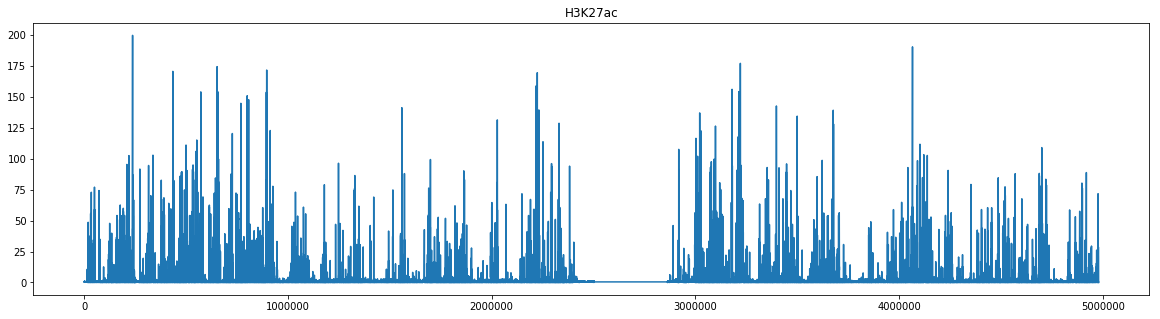

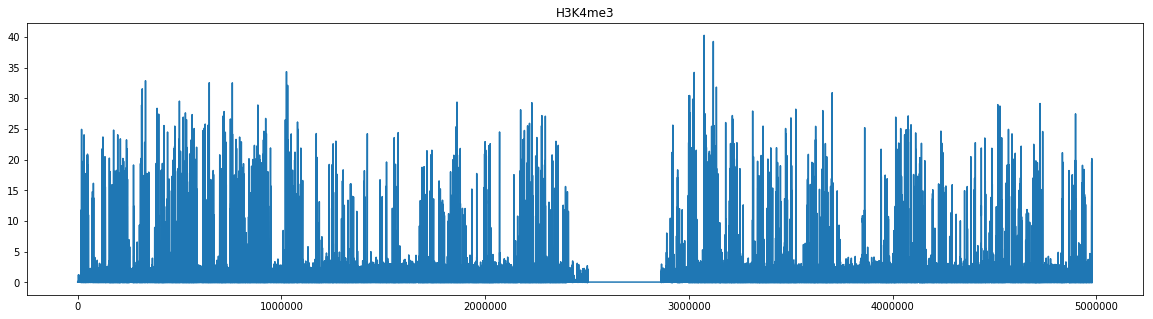

In [41]:
plt.figure(figsize=(20,5))
plt.plot(chrom1_clean_50_binned_ac)
plt.title('H3K27ac')
plt.show()
plt.figure(figsize=(20,5))
plt.plot(chrom1_clean_50_binned) # Plotting H3K4me3 again so we can compare inputs and outputs together
plt.title('H3K4me3')
plt.show()

Looks pretty good, somewhat correlated. We zoom a bit:


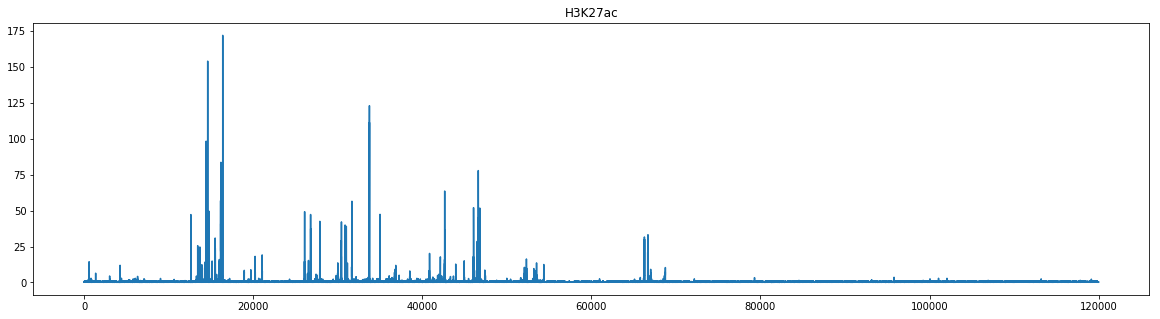

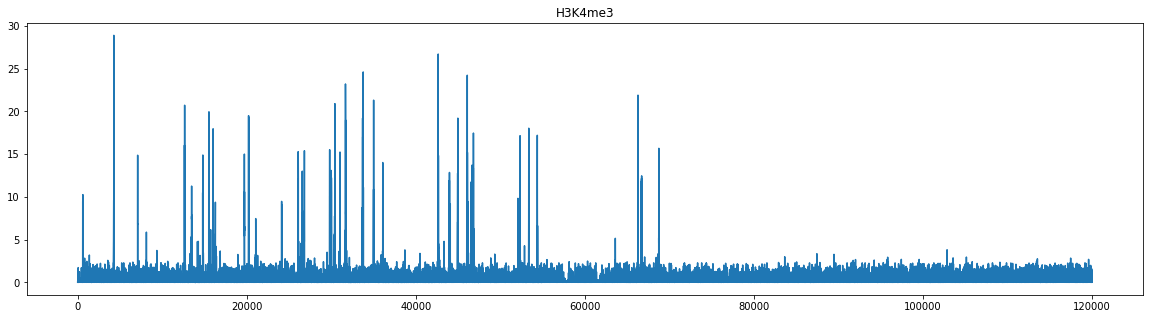

In [44]:
plt.figure(figsize=(20,5))
plt.plot(chrom1_clean_50_binned_ac[880000:1000000])
plt.title('H3K27ac')
plt.show()
plt.figure(figsize=(20,5))
plt.plot(chrom1_clean_50_binned[880000:1000000]) # Plotting H3K4me3 again so we can compare inputs and outputs together
plt.title('H3K4me3')
plt.show()

We see that it's not identical but there is a strong correlation between the signal profiles. Now, onto building our Convolutional Neural Network (CNN) model. CNNs have been quite useful for biological applications, easier to train than Dense Neural Networks (DNN), and do comparably well when it comes to accuracy. One of the main feature of CNNs is that, neurons in a layer connect to few of the nearby neurons in preceeding layer. (DNN neurons connect to all of the neurons in preceeding layer) More on CNNs: http://cs231n.github.io/convolutional-networks/

Neural network can't take an input size that's too large. For that reason, we have to divide up our entire dataset into samples. Each sample will be a slice of the chromosome representing gene region of fixed size. Suppose we want input and output samples to cover 5000bp, this means we need to slice the entire range into slices of size 1000 elements. (1000 x 50 = 5000pb since each element is averaged signal p-value over 50pb)  Here is the current shape of our data.

In [45]:
print(chrom1_clean_50_binned.shape)

(4979128,)


Shape after slicing it up into samples:

In [78]:
gene_region_size = 1000

In [79]:
# Using array slice operator to get the elements that is evenly divisible by 1000
inputs = chrom1_clean_50_binned[:(-(len(chrom1_clean_50_binned) % gene_region_size))]
print(len(inputs))

outputs = chrom1_clean_50_binned_ac[:(-(len(chrom1_clean_50_binned_ac) % gene_region_size))]
print(len(outputs))



input_samples = inputs.reshape(-1, gene_region_size) 
output_samples = outputs.reshape(-1, gene_region_size)

print('Input shape ', input_samples.shape) 
print('Output shape ', output_samples.shape)
print('{} samples of size {} each'.format(input_samples.shape[0], input_samples.shape[1]))

4979000
4979000
Input shape  (4979, 1000)
Output shape  (4979, 1000)
4979 samples of size 1000 each


We will split the data into training and test sets. Holding out some of the data as a test set allows us to check the accuracy of the model that's trained on the training set. Test set is a holdout, model never sees it. If the model can predict the outputs of the test set based on the inputs of the test set after it has been trained, this could mean that model has the predictive potential for a general dataset of this kind.  

In [80]:
# Features are inputs from which we predict the output labels
train_features, test_features, train_labels, test_labels = train_test_split(
    input_samples, output_samples, test_size=0.25, random_state=42)

In [126]:
# Sorting samples so that high signal regions influence the model parameters early on
train_labels_mean = np.mean(train_labels, axis=1)
sorted_indices = train_labels_mean.argsort()[::-1]
train_features = train_features[sorted_indices]
train_labels = train_labels[sorted_indices]

# Extra dimension is so keras library won't complain, data is same
train_features = train_features.reshape(-1, gene_region_size, 1)
test_features = test_features.reshape(-1, gene_region_size, 1)

Model layers:

In [238]:
filter_size = 16
kernel_size = 4

model = Sequential()

# Initial CNN layer, 25 neurons, each connecting to 4 previous
model.add(Conv1D(filters=filter_size, 
                 kernel_size=kernel_size, 
                 activation='relu', 
                 input_shape=(train_features.shape[1], train_features.shape[2]), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling1D(pool_size=2)) # https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks
model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', dilation_rate=2, padding='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', dilation_rate=4, padding='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', dilation_rate=8, padding='same'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', dilation_rate=16, padding='same'))
model.add(Flatten()) # We flatten the dimensions so the data eventually gets in to the same shape as the labels
model.add(Dense(train_labels.shape[1], activation='relu')) # Final dense layer is for capturing distal effects

#model.compile(loss=correlation_coefficient_loss, optimizer='adam', metrics=['poisson', 'acc'])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['poisson', 'acc'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_195 (Conv1D)          (None, 1000, 16)          80        
_________________________________________________________________
batch_normalization_60 (Batc (None, 1000, 16)          4000      
_________________________________________________________________
max_pooling1d_98 (MaxPooling (None, 500, 16)           0         
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 500, 16)           1040      
_________________________________________________________________
batch_normalization_61 (Batc (None, 500, 16)           2000      
_________________________________________________________________
max_pooling1d_99 (MaxPooling (None, 250, 16)           0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 250, 16)           1040      
__________

In [239]:
# We are again splitting the training set into two sets: train and validation sets
# Validation set is withheld from each training epoch
# At the end of each epoch, loss for validation set is calculated
# For model to be generizeable, losses for validation and training should go down together
# If loss for traning goes down but validation loss goes up, then we have overfitting problem
# Overfitting means that model only does well for the data it's trained on
# We usually stop training when overfitting starts to occur. 
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=20)]

history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=1, validation_split=0.2, callbacks=callbacks)

Train on 2987 samples, validate on 747 samples
Epoch 1/50
2987/2987 [==============================] - 20s 7ms/step - loss: 6.7657 - poisson: 1.7136 - acc: 0.0027 - val_loss: 0.0935 - val_poisson: 1.0907 - val_acc: 0.0040
Epoch 2/50
2987/2987 [==============================] - 5s 2ms/step - loss: 6.2602 - poisson: 1.3648 - acc: 0.0030 - val_loss: 0.0643 - val_poisson: 0.8403 - val_acc: 0.0000e+00
Epoch 3/50
2987/2987 [==============================] - 5s 2ms/step - loss: 5.9728 - poisson: 1.3504 - acc: 0.0090 - val_loss: 0.0767 - val_poisson: 0.8531 - val_acc: 0.0013
Epoch 4/50
2987/2987 [==============================] - 5s 2ms/step - loss: 5.8402 - poisson: 1.5518 - acc: 0.0067 - val_loss: 0.0765 - val_poisson: 0.8878 - val_acc: 0.0000e+00
Epoch 5/50
2987/2987 [==============================] - 5s 2ms/step - loss: 5.4804 - poisson: 1.7222 - acc: 0.0094 - val_loss: 0.1069 - val_poisson: 0.9250 - val_acc: 0.0000e+00
Epoch 6/50
2987/2987 [==============================] - 5s 2ms/step - 

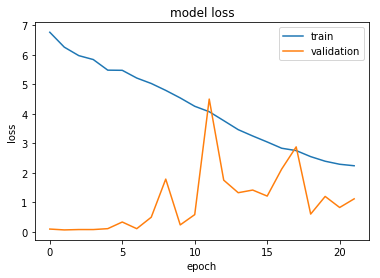

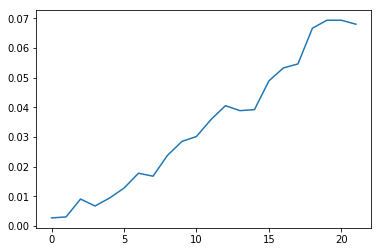

In [240]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
# Accuracy increased a bit, and then started decreasing
plt.plot(history.history['acc'])
plt.show()

Accuracy here is based on number of times model exactly predicted the target labels. It's impossible to come up with exact signal p-values as a prediction even if our models weren't bad and not hastily put together. Important question to ask is whether the model is prediction peaks at places where there are real peaks. Remember the test data set we withheld and never let the model see it? Test data set had both methylation inputs and acetylation outputs for the exact gene regions. Lets see what model predicts for the inputs and compare the prediction to true output:

In [235]:
prediction = model.predict(test_features).flatten()

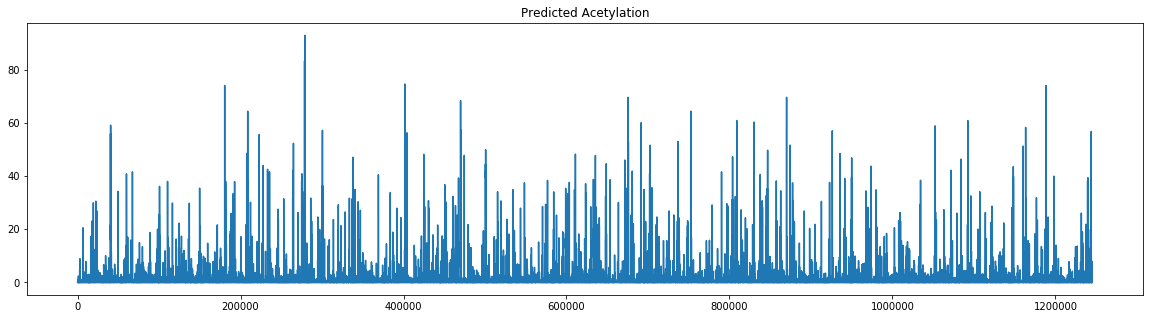

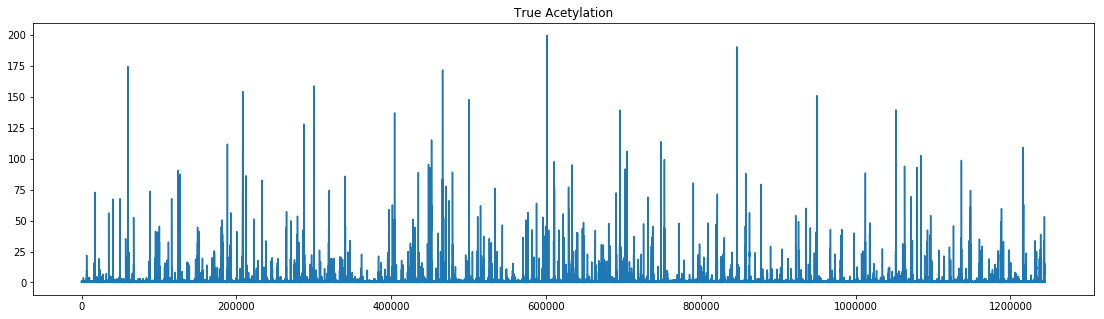

In [236]:
plt.figure(figsize=(20,5))
plt.plot(prediction.flatten())
plt.title('Predicted Acetylation')
plt.show()

# Now true acetylation
plt.figure(figsize=(19,5))
plt.plot(test_labels.flatten())
plt.title('True Acetylation')
plt.show()

Hard to see the correlation... Let's zoom in

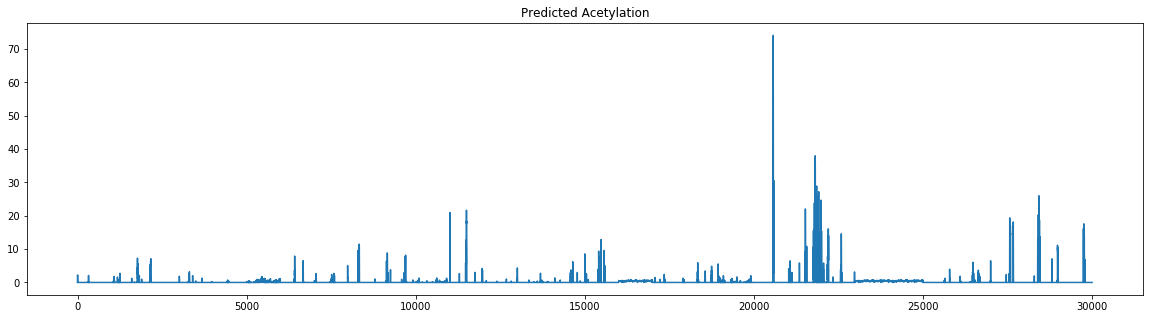

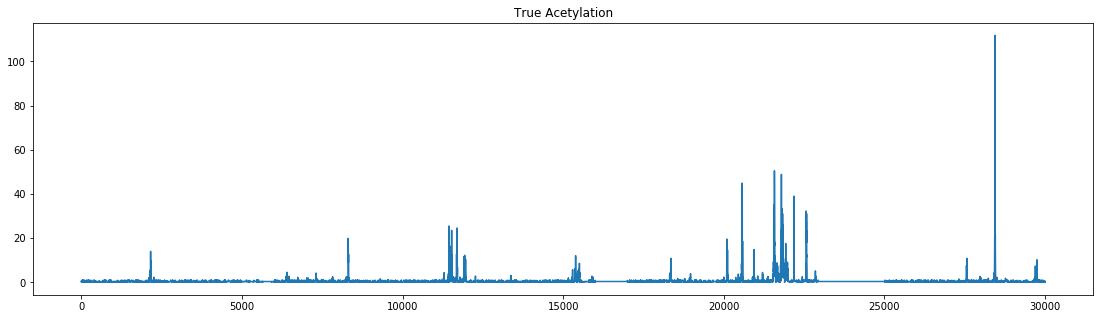

In [237]:
plt.figure(figsize=(20,5))
plt.plot(prediction.flatten()[160000:190000])
plt.title('Predicted Acetylation')
plt.show()

# Now true acetylation
plt.figure(figsize=(19,5))
plt.plot(test_labels.flatten()[160000:190000])
plt.title('True Acetylation')
plt.show()

Model learnt something, but not very well. It's lacking precision and we could have normalized the values. It's bad but not too bad given that we had very small data (chrom1) to train and test with. Normally, we would train on at least three chromosomes, and use two other chromosomes for validation and testing. Here are some interesting questions after this exercise:

- Which chromosomes we should train the model with?
- What other CNN model structure we could try?
- Is maxpooling making the model loose resolution?
- Would more layers help?
- Would normalizing the data help?
- What other loss functions can we try? How about metrics?
- Would data from another histone modification as a joint input help the model performance?
- Would the sequence data from the refence assembly help the model learn better?
- We converted the missing values to zeros. Does that mean that there is no signal in truth?
- How does many zeros affect neural networks or any statistical models trained with mean squared error loss function?
- What other interesting questions would you add here?
